In [691]:
! which python3
! python3 -V

/home/mykmur/dev/venv/bin/python3
Python 3.8.15


In [692]:
import typing as t
import jraph
import jax.numpy as jnp
import metadata
import haiku as hk
import utils
import jax
import optax

In [693]:
WINDOW = int(31*12*24*60/5)
VIS = False

In [694]:
def create_graph_tuple(senders, receivers, edges) -> jraph.GraphsTuple:
    return jraph.GraphsTuple(
        nodes=None,
        edges=edges,
        senders=senders,
        receivers=receivers,
        n_node=jnp.asarray([metadata.NUM_NODES]),
        n_edge=jnp.asarray([metadata.NUM_EDGES]),
        globals=None)

In [695]:
_senders = []
_receivers = []

for x, row in enumerate(metadata.ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if metadata.ADJACENCY_MATRIX[x][y]:
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
nodes = jnp.array([1] * metadata.NUM_NODES)
edges = jnp.array([1] * metadata.NUM_EDGES)

graph_features = jnp.array([[1]])
graph = create_graph_tuple(senders, receivers, edges)

if VIS:
    utils.draw_jraph_graph_structure(graph)

### Load data

In [696]:
import pandas as pd

In [697]:
df = pd.read_pickle("../data/samples_5m_subset_v1.pkl")

In [698]:
def get_data_for_link(src: str, dst: str) -> jnp.array:
    ss: pd.Series = df[(df["src_host"] == src) & (df["dst_host"] == dst)]
    return ss.incoming_rate_avg.to_numpy()

In [699]:
_map = metadata.NODE_IDS_TO_LABELS_MAPPING

_senders = []
_receivers = []
_edges = jnp.array([[]])

for x, row in enumerate(metadata.ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if metadata.ADJACENCY_MATRIX[x][y]:
            _edges = jnp.append(_edges,
                get_data_for_link(_map[x], _map[y]))
                
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
edges = jnp.array(_edges.reshape((metadata.NUM_EDGES, int(len(_edges)/metadata.NUM_EDGES))))

In [700]:
graph = create_graph_tuple(senders, receivers, edges)

In [701]:
if VIS:
    utils.draw_jraph_graph_structure(graph)

### Model

In [702]:
HIDDEN_SIZE = 32
LEARNING_RATE = 1e-3
SPLIT = 0.9
BLOCK_SIZE = int(7*24*60/5)  # 1 day
BATCH_SIZE = 32
SEED = 1237
NUM_TRAINING_STEPS = 500
EVAL_INTERVAL = 5

In [703]:
n = int(SPLIT * edges.shape[1])
d_train = edges[0][:n]
d_val = edges[0][n:]

In [704]:
d_train = jnp.log(d_train)
d_val = jnp.log(d_val)

In [705]:
d_val.shape, d_train.shape, edges.shape

((16227,), (146043,), (15, 162270))

In [706]:
class TrainingState(t.NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

class LoopValues(t.NamedTuple):
    tokens: jnp.ndarray
    state: t.Any
    rng_key: jnp.ndarray

Batch = t.Mapping[str, jnp.ndarray]

In [707]:
the_seed = hk.PRNGSequence(SEED)

def get_batch(split: str) -> Batch:
    data = d_train if split == "train" else d_val
    ixs = jax.random.randint(next(the_seed), (BATCH_SIZE, ), 0, len(data) - BLOCK_SIZE)
    x = jnp.stack([data[i:i+BLOCK_SIZE] for i in ixs])
    y = jnp.stack([data[i+1:i+BLOCK_SIZE+1] for i in ixs])
    return {'input': x, 'target': y}

In [708]:
expl_batch = get_batch("train")

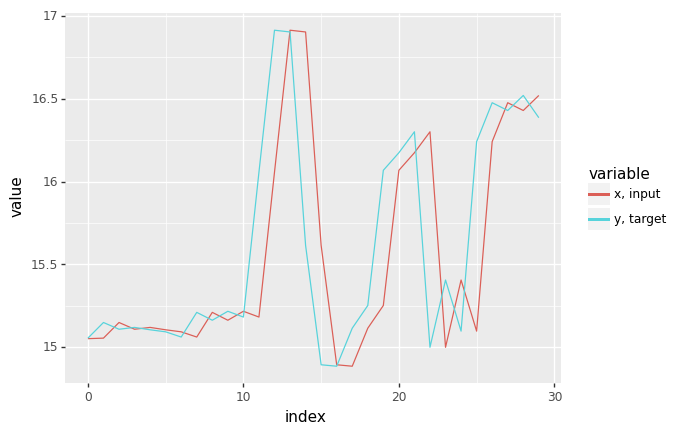

In [709]:
_off = 30
plot = utils.plot_samples(
    truth=expl_batch['target'][0, :_off], 
    prediction=expl_batch['input'][0, :_off],
    truth_label='y, target',
    prediction_label='x, input')
plot.draw()

In [710]:
def make_network() -> hk.Module:
    """Defines the network architecture."""
    model = hk.DeepRNN([
        hk.LSTM(HIDDEN_SIZE),
        jax.nn.relu,
        hk.LSTM(HIDDEN_SIZE),
        hk.Linear(BLOCK_SIZE),
    ])
    return model

def make_optimizer() -> optax.GradientTransformation:
    """Defines the optimizer."""
    return optax.adam(LEARNING_RATE)

In [711]:
def sequence_loss(batch: Batch) -> jnp.ndarray:
    """Unrolls the network over a sequence of inputs & targets, gets loss."""
    core = make_network()
    batch_size, sequence_length = batch['input'].shape  # (B, T) 

    initial_state = core.initial_state(batch_size)
    # _input = jnp.expand_dims(batch['input'], -1) # (B, T, 1)
    _input = batch['input'] # (B, T)
    # print(f"_input shape = {_input.shape}")
    # logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)
    logits, _ = core(_input, initial_state)
    # print(f"logits shape = {logits.shape}")
    # logits -> (B, T)
    # batch['target'] -> (B, T)
    # loss = jnp.mean(jnp.square(logits[:, :, -1] - batch['target']))  # MSE
    loss = jnp.mean(jnp.abs(batch['target'] - logits))  # MAE
    return loss

In [712]:
@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
    """Does a step of SGD given inputs & targets."""
    _, optimizer = make_optimizer()
    _, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
    gradients = jax.grad(loss_fn)(state.params, batch)
    updates, new_opt_state = optimizer(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    return TrainingState(params=new_params, opt_state=new_opt_state)

In [713]:
expl_batch['target'].shape

(32, 2016)

In [714]:
rng = hk.PRNGSequence(SEED)

init_params_fn, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
initial_params = init_params_fn(next(rng), expl_batch)
opt_init, _ = make_optimizer()
initial_opt_state = opt_init(initial_params)

# de facto initial state
state = TrainingState(params=initial_params, opt_state=initial_opt_state)

In [715]:
loss_fn = jax.jit(loss_fn)

In [716]:
train_loss_all = jnp.array([])
eval_loss_all = jnp.array([])

for step in range(NUM_TRAINING_STEPS):
    train_batch = get_batch("train")
    state = update(state, train_batch)

    if step % EVAL_INTERVAL == 0:
        eval_batch = get_batch("eval")
        train_loss = loss_fn(state.params, train_batch)
        eval_loss = loss_fn(state.params, eval_batch)
        train_loss_all = jnp.append(train_loss_all, train_loss)
        eval_loss_all = jnp.append(eval_loss_all, eval_loss)
        print({
            'step': step,
            'train_loss': float(train_loss),
            'eval_loss': float(eval_loss),
        })

final_state = state

{'step': 0, 'train_loss': 16.820220947265625, 'eval_loss': 16.83380889892578}
{'step': 5, 'train_loss': 16.80992317199707, 'eval_loss': 16.8281192779541}
{'step': 10, 'train_loss': 16.81378936767578, 'eval_loss': 16.80921173095703}
{'step': 15, 'train_loss': 16.768938064575195, 'eval_loss': 16.795307159423828}
{'step': 20, 'train_loss': 16.699228286743164, 'eval_loss': 16.791114807128906}
{'step': 25, 'train_loss': 16.634672164916992, 'eval_loss': 16.713565826416016}
{'step': 30, 'train_loss': 16.668113708496094, 'eval_loss': 16.62952423095703}
{'step': 35, 'train_loss': 16.603628158569336, 'eval_loss': 16.671335220336914}
{'step': 40, 'train_loss': 16.56653594970703, 'eval_loss': 16.55017852783203}
{'step': 45, 'train_loss': 16.421009063720703, 'eval_loss': 16.492204666137695}
{'step': 50, 'train_loss': 16.456159591674805, 'eval_loss': 16.397640228271484}
{'step': 55, 'train_loss': 16.38306999206543, 'eval_loss': 16.325220108032227}
{'step': 60, 'train_loss': 16.253477096557617, 'eval

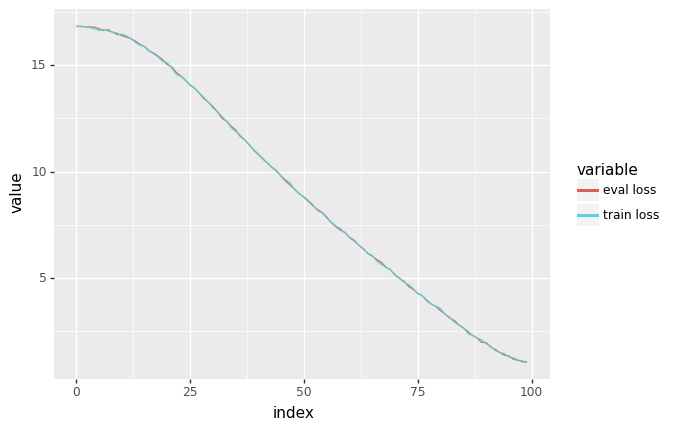

In [718]:
plot = utils.plot_samples(
    truth=train_loss_all, 
    prediction=eval_loss_all,
    truth_label='train loss',
    prediction_label='eval loss')
plot.draw()

### Generating data from the model

In [755]:
def generate(
    context: jnp.ndarray,
) -> jnp.ndarray:
    """Draws samples from the model, given an initial context."""
    assert context.ndim == 1  # a single batch

    core = make_network()

    initial_state = core.initial_state(None)
    _input = jnp.expand_dims(context, 0) # (1, T) 
    # logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)
    logits, _ = core(context, initial_state)
    return logits

In [756]:
_, sample_fn = hk.without_apply_rng(hk.transform(generate))
sample_fn = jax.jit(sample_fn)

In [757]:
context = d_val[1714:1714+BLOCK_SIZE]

SEQ_LEN = 100
predictions = jnp.array([0.]*SEQ_LEN)
for step in range(SEQ_LEN):
    samples = sample_fn(final_state.params, context)
    context = jnp.append(context[1:], jnp.mean(samples))
    predictions = predictions.at[step].set(jnp.mean(samples))
print(predictions.shape)

(100,)


In [758]:
daa = jnp.append(d_val[1714:1714+BLOCK_SIZE], predictions)

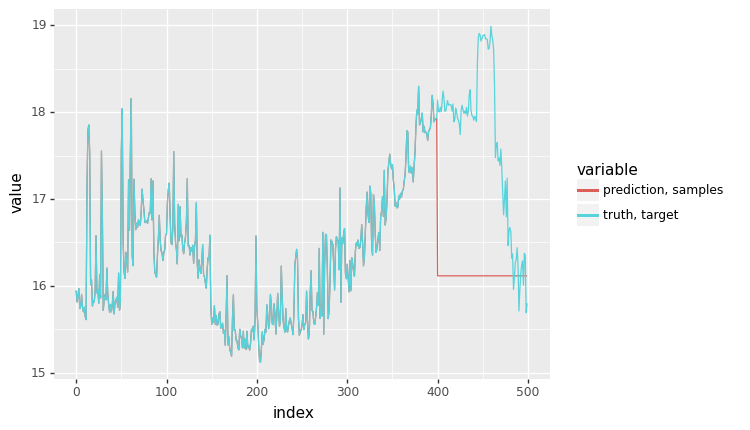

In [759]:
_offset = 2
plot = utils.plot_samples(
    d_val[1714:1714+BLOCK_SIZE+SEQ_LEN][-500:],
    daa[-500:],
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()

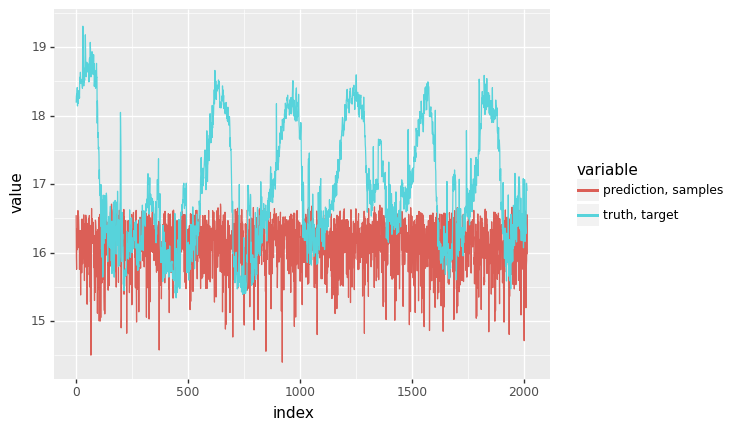

In [760]:
sample_batch = get_batch("eval")
context = sample_batch['input'][0, :]
samples = sample_fn(final_state.params, context)
_offset = 2
plot = utils.plot_samples(
    context,
    samples,
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()